# Importing Packages 

In [48]:
#!pip install tqdm
#!pip install nltk
#!pip install matplotlib
#!pip install tensorflow_hub
#!pip install tensorflow_datasets
#!pip install  obspy
#!pip install tensorflow_datasets
#!pip install tensorflow_hub
import sys
print(sys.executable)
import tensorflow_datasets as tfds

/home/chiangwe/anaconda3/envs/NetHawkes/bin/python


In [49]:
#============ Importing Packages ============# 

#--------- Drawing Packages ---------#

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, NullFormatter, LogLocator)
from set_size import set_size
from collections import Counter
import tensorflow_hub as hub

#--------- Utilities Packages ---------#
import os
import re
import pdb
import shelve
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from tqdm import tqdm

import nltk
import obspy
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('word_tokenize')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Scipy Signal
from scipy import signal
# Detrend the Signal
from obspy.signal.detrend import polynomial

#stop_words = set(stopwords.words('english')) 

#--------- Analiing results  ---------#

#import xgboost
#import shap

#--------- Remove Warnings ---------#
import warnings
warnings.filterwarnings("ignore")


# Checking the statistics

In [11]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
display(df.head(5))
print(df['down_votes'].sum())
print("It doesn' have down_votes.")

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


0
It doesn' have down_votes.


Number of posts:  509236
Date range:  (Timestamp('2008-01-25 00:00:00'), Timestamp('2016-11-22 00:00:00'))  tol days:  3224 days 00:00:00
Stats for number of reddits from posts:


,count,mean,std,min,25%,50%,75%,max
n_post,3223.0,158.000621,97.360446,1.0,74.0,129.0,241.0,458.0


,count,mean,std,min,25%,50%,75%,max
up_votes,3223.0,90.152178,65.953134,1.245902,35.178536,79.960396,128.165878,477.19084
down_votes,3223.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


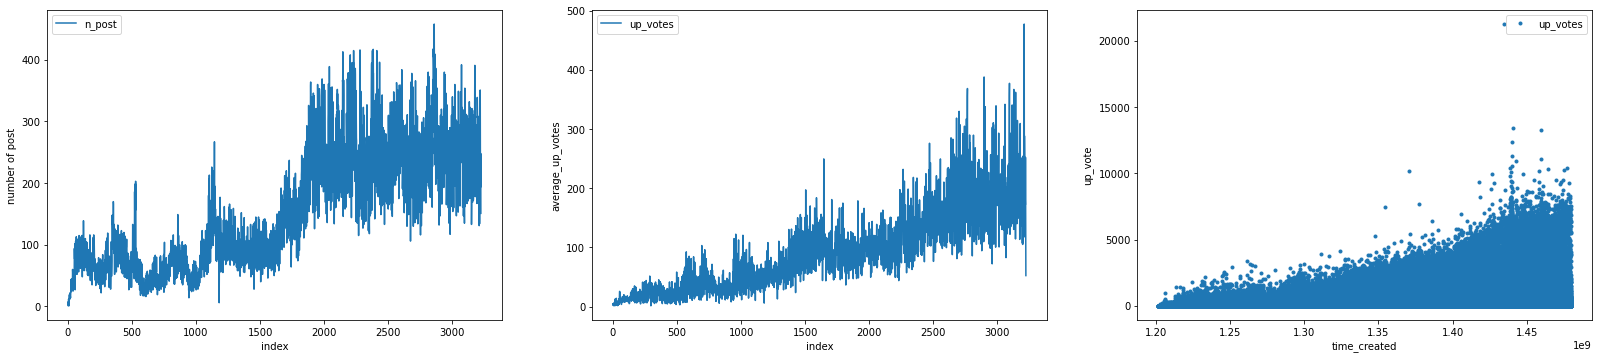

In [12]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(width=4000, height_adjust=1, fraction=0.5, subplots=(1,3)))
print("Number of posts: ", df.shape[0])

# Check dates stats
min_date = pd.to_datetime(df['date_created'].min());
max_date = pd.to_datetime(df['date_created'].max());

print("Date range: ", (min_date, max_date), " tol days: ", max_date-min_date )
print("Stats for number of reddits from posts:")

n_po = pd.DataFrame( df.groupby('date_created')['title'].count().rename('n_post') )
avg_votes = pd.DataFrame( df.groupby('date_created')['up_votes', 'down_votes'].mean() )
display(n_po.describe().T)
display(avg_votes.describe().T)

ax1  = n_po.reset_index().reset_index().plot.line(x='index', y='n_post', rot=0, ylabel='number of post', ax=ax1)
ax2 = avg_votes.reset_index().reset_index().plot.line(x='index', y='up_votes', rot=0, ylabel='average_up_votes', ax=ax2)
ax3 = df.plot.line(x='time_created', y='up_votes', rot=0, ylabel='up_vote', style='.', ax=ax3)



### We can not just use mean up_vote to lable popular 
### Reddit has a user growth that reflect to the upvote trend
### We will use the previous four weeks of day of the week to decide the label
### Popular: more the average 

In [13]:
# Check vote stats

df_avg_count = df.groupby(['date_created']).apply(lambda x: ( x['up_votes'].sum(), x['up_votes'].count()  ) ).reset_index()
df_avg_count['sum'] = df_avg_count[0].apply(lambda x: x[0])
df_avg_count['cnt'] = df_avg_count[0].apply(lambda x: x[1])

df_avg_count = df_avg_count[['date_created', 'sum', 'cnt']].set_index('date_created')


date_index =  [ each.strftime("%Y-%m-%d") for each in \
               pd.date_range(start=min_date.strftime("%Y-%m-%d"), end=max_date.strftime("%Y-%m-%d"))]
df_avg_count = df_avg_count.reindex(date_index, fill_value=0)
#df_avg_count['tol_val'] = df_avg_count.apply(lambda x: x['avg']*x['cnt'], axis=1)

def every_seven_day(values):
    N = len(values)
    output =  np.sum(values)
    return output

df_avg_count['sum'] = df_avg_count['sum'].rolling(28).apply(every_seven_day, raw=True)
df_avg_count['cnt'] = df_avg_count['cnt'].rolling(28).apply(every_seven_day, raw=True)
df_avg_count['avg_weekly'] = df_avg_count.apply(lambda x: x['sum']/x['cnt'], axis= 1)
df_avg_count.reset_index()[['date_created', 'avg_weekly']]

dict_thresh = df_avg_count.reset_index()[['date_created', 'avg_weekly']].iloc[27:, :];
first_date = dict_thresh['date_created'].min()
dict_thresh = dict(zip(dict_thresh['date_created'],dict_thresh['avg_weekly'] ))

df_sel = df[df['date_created']>=first_date].reset_index(drop=True)
df_sel['label']     = df_sel.apply(lambda x: x['up_votes'] >= dict_thresh[x['date_created']], axis=1) 
df_sel['threshold'] = df_sel.apply(lambda x: dict_thresh[x['date_created']], axis=1) 

#display(df[df['date_created'] == '2016-11-22'])
display(  df[df['date_created'] == '2016-11-22'].sort_values('up_votes').tail(20)  )


,time_created,date_created,up_votes,down_votes,title,over_18,author,category
509191,1479810775,2016-11-22,18,0,56-car pileup in China leaves 17 dead,False,LenonTV,worldnews
509188,1479810217,2016-11-22,19,0,World s First Head Transplant Will Use Virtual...,False,Short_Term_Account,worldnews
509200,1479812515,2016-11-22,19,0,Extraordinarily hot Arctic temperatures alar...,False,rawrstevo,worldnews
509155,1479801913,2016-11-22,23,0,British Navy fire warning shots at Spanish Nav...,False,cholopapi,worldnews
509167,1479805472,2016-11-22,26,0,Turkey to drop child-sex assault bill after pr...,False,ICASL,worldnews
509208,1479813152,2016-11-22,41,0,Eagles destroy nine WA mining drones and cost ...,False,Short_Term_Account,worldnews
509102,1479783131,2016-11-22,43,0,Death toll in India train derailment hits 146,False,doctor316,worldnews
509178,1479808720,2016-11-22,45,0,Turkish President Erdogan: I can t say if Isr...,False,ICASL,worldnews
509093,1479777027,2016-11-22,47,0,Vancouver mayor on housing crisis: I never dr...,False,ManiaforBeatles,worldnews
509131,1479793320,2016-11-22,70,0,British PM signals £2bn a year science funding...,False,cyanocittaetprocyon,worldnews


Number of pos:  53996  Out of:  508901
53996


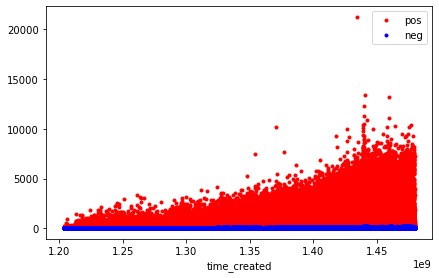

In [14]:
fig1, ax1 = plt.subplots(1, 1, figsize=set_size(width=1000, height_adjust=1, fraction=0.5, subplots=(1,1)))
ax1 = df_sel[df_sel['label'] == True].plot.line(x='time_created', y='up_votes', rot=0, style='.', color='red' , ax=ax1)
ax1 = df_sel[df_sel['label'] == False].plot.line(x='time_created', y='up_votes', rot=0, style='.', color='blue' , ax=ax1)
ax1.legend(['pos','neg'])
print("Number of pos: ", df_sel['label'].values.sum(), " Out of: ", df_sel.shape[0])

print( df_sel['label'].values.sum() )

#### If we only use average to determine, very popular posts will cause strong bias.
#### 075 percientt uqnatin 

In [15]:
date_index =  [ each.strftime("%Y-%m-%d") for each in \
               pd.date_range(start=min_date.strftime("%Y-%m-%d"), end=max_date.strftime("%Y-%m-%d"))]
df_array = df.groupby(['date_created']).apply(lambda x: np.stack(x['up_votes'])).rename('array').reindex(date_index, fill_value=[]).reset_index()
#display(df_array)
df_array['date_created_ym'] =  df_array['date_created'].apply( lambda x: pd.to_datetime(x).strftime('%Y-%m'))
df_ym_quan = df_array.groupby('date_created_ym').apply(lambda x: np.quantile( np.hstack(x['array']), 0.75) ).rename('thresh').reset_index()

#df_array['075percent'] = df_array.rolling(28).apply(lambda x: every_seven_day(x['array']), raw=True)

#display(df_ym_quan)
dict_thresh = dict(zip(df_ym_quan['date_created_ym'],df_ym_quan['thresh'] ))

In [16]:
df_sel['label']     = df_sel.apply(lambda x: x['up_votes'] >= dict_thresh[x['date_created'][0:7]], axis=1) 
df_sel['threshold'] = df_sel.apply(lambda x: dict_thresh[x['date_created'][0:7]], axis=1) 
display(df_sel)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,label,threshold
0,1203577161,2008-02-21,3,0,US Reactions To Pakistan Election Results Mixed,False,igeldard,worldnews,False,5.0
1,1203577230,2008-02-21,3,0,Iraq Unemployment Too Becomes an Epidemic,False,igeldard,worldnews,False,5.0
2,1203577396,2008-02-21,9,0,Taxpayers left with Northern Rock rubbish th...,False,igeldard,worldnews,True,5.0
3,1203577541,2008-02-21,8,0,Britain s FEMALE Spitfire pilots to receive ba...,False,igeldard,worldnews,True,5.0
4,1203584599,2008-02-21,4,0,E. Timor s Ramos-Horta Out of Coma,False,PaperLess,worldnews,False,5.0
...,...,...,...,...,...,...,...,...,...,...
508896,1479816764,2016-11-22,5,0,Heil Trump : Donald Trump s alt-right white...,False,nonamenoglory,worldnews,False,21.0
508897,1479816772,2016-11-22,1,0,There are people speculating that this could b...,False,SummerRay,worldnews,False,21.0
508898,1479817056,2016-11-22,1,0,Professor receives Arab Researchers Award,False,AUSharjah,worldnews,False,21.0
508899,1479817157,2016-11-22,1,0,Nigel Farage attacks response to Trump ambassa...,False,smilyflower,worldnews,False,21.0


Number of pos:  130251  Out of:  508901
130251


,time_created,date_created,up_votes,down_votes,title,over_18,author,category,label,threshold
506195,1478906001,2016-11-11,1,0,Brazil politicians linked to Petrobras scandal...,False,CodDex,worldnews,False,21.0
507895,1479457557,2016-11-18,1,0,Many Indians are offering to donate their kidn...,False,bitoffreshair,worldnews,False,21.0
507907,1479461501,2016-11-18,1,0,"Abe Woos Trump With Golf, Just Like His Grandf...",False,ManiaforBeatles,worldnews,False,21.0
507917,1479464178,2016-11-18,1,0,David Attenborough gets his own app,False,Heskimo88,worldnews,False,21.0
507919,1479464299,2016-11-18,1,0,Victims group withdraws from historical child...,False,Ammar_Shabbir,worldnews,False,21.0
...,...,...,...,...,...,...,...,...,...,...
504278,1478142085,2016-11-03,1,0,Mosul battle: Militiamen torture IS suspects...,False,phuocnguyen286,worldnews,False,21.0
504504,1478204036,2016-11-03,1,0,At least 19 killed after trains crash in Pakistan,False,Hypatia_Alexandria_,worldnews,False,21.0
504280,1478142852,2016-11-03,1,0,Search Resumes for 44 Missing From Indonesia B...,False,pitinglistrik,worldnews,False,21.0
504286,1478144678,2016-11-03,1,0,Hong Kong may ask Beijing to intervene over pr...,False,cyanocittaetprocyon,worldnews,False,21.0


,count,mean,std,min,25%,50%,75%,max
time_created,5252.0,1.478898e+09,557894.104697,1.477959e+09,1.478374e+09,1.478950e+09,1.479377e+09,1.479817e+09
up_votes,5252.0,1.938006e+02,849.791156,0.000000e+00,2.000000e+00,6.000000e+00,2.100000e+01,9.298000e+03
down_votes,5252.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
threshold,5252.0,2.100000e+01,0.000000,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01


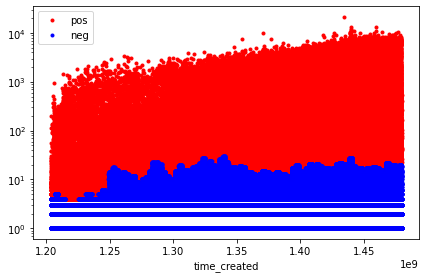

In [17]:
fig1, ax1 = plt.subplots(1, 1, figsize=set_size(width=1000, height_adjust=1, fraction=0.5, subplots=(1,1)))
ax1 = df_sel[df_sel['label'] == True].plot.line(x='time_created', y='up_votes', rot=0, style='.', color='red' , ax=ax1)
ax1 = df_sel[df_sel['label'] == False].plot.line(x='time_created', y='up_votes', rot=0, style='.', color='blue' , ax=ax1)
ax1.legend(['pos','neg'])
ax1.set_yscale('log')
print("Number of pos: ", df_sel['label'].values.sum(), " Out of: ", df_sel.shape[0])

print( df_sel['label'].values.sum() )
display( df_sel[df_sel['date_created'] >= '2016-11-01'].sort_values('up_votes').head(1000).tail(300)  )
display(df_sel[df_sel['date_created'] >= '2016-11-01'].describe().transpose())

In [11]:
#df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [95]:
# read-in contractions
contractions = pd.read_csv('contractions.csv')
display(contractions.head(5))
contractions = dict(zip(contractions['contract'], contractions['orig']))

,contract,orig
0,ain't,am not / are not / is not / has not / have not
1,aren't,are not / am not
2,can't,cannot
3,can't've,cannot have
4,'cause,because


In [96]:
def clean_text(text):
    '''Text Preprocessing '''
    remove_stopwords = True
    # Convert words to lower case
    text = text.lower()
    
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    
    # Lemmatize each token
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    
    return text

In [99]:
df_sel['title_clean'] = df_sel.apply(lambda x: clean_text(x['title']), axis=1)
df_sel['title_clean'] = df_sel['title_clean'].apply(lambda x: ["".join(each) for each in x])

In [107]:
df_sel.head(20)
#df_sel.to_csv('Eluvio_DS_Challenge_processes.csv', index=False)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,label,threshold,title_clean
0,1203577161,2008-02-21,3,0,US Reactions To Pakistan Election Results Mixed,False,igeldard,worldnews,False,5.0,"[us, reactions, pakistan, election, results, m..."
1,1203577230,2008-02-21,3,0,Iraq Unemployment Too Becomes an Epidemic,False,igeldard,worldnews,False,5.0,"[iraq, unemployment, becomes, epidemic]"
2,1203577396,2008-02-21,9,0,Taxpayers left with Northern Rock rubbish th...,False,igeldard,worldnews,True,5.0,"[taxpayers, left, northern, rock, rubbish, tha..."
3,1203577541,2008-02-21,8,0,Britain s FEMALE Spitfire pilots to receive ba...,False,igeldard,worldnews,True,5.0,"[britain, female, spitfire, pilots, receive, b..."
4,1203584599,2008-02-21,4,0,E. Timor s Ramos-Horta Out of Coma,False,PaperLess,worldnews,False,5.0,"[e, timor, ramos, horta, coma]"
5,1203586639,2008-02-21,0,0,Biggest Brain Drain From UK In 50 Years,False,ThyLabyrinth,worldnews,False,5.0,"[biggest, brain, drain, uk, 50, years]"
6,1203589450,2008-02-21,0,0,"Navy missile hits dying spy satellite, says P...",False,PaperLess,worldnews,False,5.0,"[navy, missile, hits, dying, spy, satellite, s..."
7,1203590839,2008-02-21,5,0,Israeli MP blames tolerance of gays for earthq...,False,moriquendo,worldnews,True,5.0,"[israeli, mp, blames, tolerance, gays, earthqu..."
8,1203591476,2008-02-21,6,0,Iranian cleric criticises Ahmadinejad for spea...,False,moriquendo,worldnews,True,5.0,"[iranian, cleric, criticises, ahmadinejad, spe..."
9,1203592553,2008-02-21,2,0,In wake of Kososvo independence senior Palesti...,False,moriquendo,worldnews,False,5.0,"[wake, kososvo, independence, senior, palestin..."


# Work on simple models

In [18]:
#============== Packages for word2vec ==============#
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#============== Packages for classification ==============#
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import normalize

from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC


In [19]:
#========= Read in =========#
df = pd.read_csv('Eluvio_DS_Challenge_processes.csv')


In [20]:
#========= TDIDF =========#

bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x = bow_converter.fit_transform(df['title_clean'])

words = bow_converter.get_feature_names()

bigram_converter = CountVectorizer(tokenizer=lambda doc: doc,ngram_range=[2,2]) 
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3])

tfidf_transform = TfidfTransformer(norm=None)
X_tfidf = tfidf_transform.fit_transform(x)

X_tfidf = normalize(X_tfidf,axis=1)


In [21]:
#========= Define Binary Labels =========#

#========= Median positive and negative =========#
y_true = df['label']
print("n_pos: ", (y_true==1).sum(), "n_neg: ", (y_true==0).sum() ) 
#========= Kfold Logistic Regression =========#

kf = KFold(n_splits=3)

ls_b_accu = []
for train_index, test_index in kf.split(X_tfidf):
    clf = LogisticRegression(random_state=0).fit(X_tfidf[train_index,:], y_true[train_index] )
    y_pred = clf.predict(X_tfidf[test_index, :])
    
    baccu = balanced_accuracy_score(y_true[test_index], y_pred)
    
    #print(baccu)
    ls_b_accu.append(baccu)
print("ls_b_accu: ", np.mean(ls_b_accu))


n_pos:  130251 n_neg:  378650
ls_b_accu:  0.500015057722


In [89]:
#========= Median positive and negative =========#
y_true = df['label']
print("n_pos: ", (y_true==1).sum(), "n_neg: ", (y_true==0).sum() ) 

# example of a model defined with the sequential api
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_true, test_size=0.33, random_state=42)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Metric
from sklearn.metrics import balanced_accuracy_score

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(zip( np.unique(y_train), class_weights))
sample
print(dict(zip( np.unique(y_train), class_weights)) )



n_pos:  130251 n_neg:  378650
{False: False, True: True}


In [84]:

# Define a simple sequential model
def create_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
    model.add(Dense(2, activation= 'relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')])
    
    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 10)                3610      
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 3         
Total params: 3,635
Trainable params: 3,635
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Callback define
patience = 3; epochs = 70;
checkpoint_filepath = './check_point/01_sim_tdidfNN_mdl.ckpt';

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='max')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, monitor='val_loss', mode='max', save_best_only=True)

# fit the model
history = model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test), \
                    epochs=epochs, batch_size=64, verbose=2, \
                    callbacks=[early_stopping, model_checkpoint_callback], class_weight=class_weights)


Epoch 1/70
INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


5328/5328 - 11s - loss: 0.6821 - binary_accuracy: 0.5621 - val_loss: 0.6499 - val_binary_accuracy: 0.6640
Epoch 2/70
INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


5328/5328 - 11s - loss: 0.6775 - binary_accuracy: 0.6104 - val_loss: 0.6909 - val_binary_accuracy: 0.5821
Epoch 3/70
5328/5328 - 10s - loss: 0.6771 - binary_accuracy: 0.6138 - val_loss: 0.6511 - val_binary_accuracy: 0.6708
Epoch 4/70
INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/01_sim_tdidfNN_mdl.ckpt/assets


5328/5328 - 10s - loss: 0.6769 - binary_accuracy: 0.6165 - val_loss: 0.7179 - val_binary_accuracy: 0.5326
Epoch 5/70
5328/5328 - 10s - loss: 0.6767 - binary_accuracy: 0.6187 - val_loss: 0.6601 - val_binary_accuracy: 0.6482
Epoch 6/70
5328/5328 - 11s - loss: 0.6765 - binary_accuracy: 0.6217 - val_loss: 0.6790 - val_binary_accuracy: 0.6202
Epoch 7/70
5328/5328 - 10s - loss: 0.6764 - binary_accuracy: 0.6205 - val_loss: 0.6722 - val_binary_accuracy: 0.6378


In [88]:

# Load model and evaluate on test
model = tf.keras.models.load_model('./check_point/01_sim_tdidfNN_mdl.ckpt')
pred_test = model.predict(X_test.toarray()) > 0.5;

from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
print( "accuracy_score: ", accuracy_score(y_test, pred_test) )
print( "balanced_accuracy_score: ", balanced_accuracy_score(y_test, pred_test) )

tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print(tn, fp, fn, tp)
print(pred_test.shape)

accuracy_score:  0.53257154426
balanced_accuracy_score:  0.570787778678
61500 63401 15098 27939
(167938, 1)


In [93]:
# Define a sequential model
# Use Token based text embedding trained on English Google News 7B corpus
def create_model(): 
    
    embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
    hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')])
    
    return model
    
# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_63 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_65 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 48,191,341
Trainable params: 48,191,341
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Train and Test seprate
X_train, X_test, y_train, y_test = train_test_split(df['title_clean'], y_true, test_size=0.33, random_state=42)

# Callback define
patience = 3; epochs = 70;
checkpoint_filepath = './check_point/02_pre_nnlm-en-dim50_mdl.ckpt';

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='max')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, monitor='val_loss', mode='max', save_best_only=True)


# fit the model
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), \
                    epochs=epochs, batch_size=64, verbose=2, \
                    callbacks=[early_stopping, model_checkpoint_callback], class_weight=class_weights)


Epoch 1/70
INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.6714 - binary_accuracy: 0.5814 - val_loss: 0.6775 - val_binary_accuracy: 0.5814
Epoch 2/70
INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.6598 - binary_accuracy: 0.6068 - val_loss: 0.6882 - val_binary_accuracy: 0.5630
Epoch 3/70
5328/5328 - 53s - loss: 0.6531 - binary_accuracy: 0.6098 - val_loss: 0.6606 - val_binary_accuracy: 0.6006
Epoch 4/70
INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.6449 - binary_accuracy: 0.6139 - val_loss: 0.6937 - val_binary_accuracy: 0.5454
Epoch 5/70
5328/5328 - 54s - loss: 0.6361 - binary_accuracy: 0.6154 - val_loss: 0.6884 - val_binary_accuracy: 0.5571
Epoch 6/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.6276 - binary_accuracy: 0.6207 - val_loss: 0.7045 - val_binary_accuracy: 0.5374
Epoch 7/70
5328/5328 - 54s - loss: 0.6203 - binary_accuracy: 0.6244 - val_loss: 0.6841 - val_binary_accuracy: 0.5613
Epoch 8/70
5328/5328 - 54s - loss: 0.6136 - binary_accuracy: 0.6272 - val_loss: 0.6892 - val_binary_accuracy: 0.5569
Epoch 9/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.6075 - binary_accuracy: 0.6277 - val_loss: 0.7074 - val_binary_accuracy: 0.5399
Epoch 10/70
5328/5328 - 53s - loss: 0.6027 - binary_accuracy: 0.6293 - val_loss: 0.7051 - val_binary_accuracy: 0.5445
Epoch 11/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5978 - binary_accuracy: 0.6305 - val_loss: 0.7252 - val_binary_accuracy: 0.5291
Epoch 12/70
5328/5328 - 54s - loss: 0.5941 - binary_accuracy: 0.6329 - val_loss: 0.6903 - val_binary_accuracy: 0.5743
Epoch 13/70
5328/5328 - 54s - loss: 0.5904 - binary_accuracy: 0.6308 - val_loss: 0.7245 - val_binary_accuracy: 0.5327
Epoch 14/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5869 - binary_accuracy: 0.6309 - val_loss: 0.7290 - val_binary_accuracy: 0.5371
Epoch 15/70
5328/5328 - 54s - loss: 0.5841 - binary_accuracy: 0.6322 - val_loss: 0.7255 - val_binary_accuracy: 0.5391
Epoch 16/70
5328/5328 - 54s - loss: 0.5813 - binary_accuracy: 0.6340 - val_loss: 0.7270 - val_binary_accuracy: 0.5526
Epoch 17/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5787 - binary_accuracy: 0.6337 - val_loss: 0.7497 - val_binary_accuracy: 0.5506
Epoch 18/70
5328/5328 - 53s - loss: 0.5771 - binary_accuracy: 0.6336 - val_loss: 0.7453 - val_binary_accuracy: 0.5375
Epoch 19/70
5328/5328 - 54s - loss: 0.5749 - binary_accuracy: 0.6335 - val_loss: 0.7454 - val_binary_accuracy: 0.5568
Epoch 20/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5729 - binary_accuracy: 0.6337 - val_loss: 0.7605 - val_binary_accuracy: 0.5468
Epoch 21/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5713 - binary_accuracy: 0.6338 - val_loss: 0.7699 - val_binary_accuracy: 0.5408
Epoch 22/70
5328/5328 - 54s - loss: 0.5694 - binary_accuracy: 0.6342 - val_loss: 0.7689 - val_binary_accuracy: 0.5336
Epoch 23/70
5328/5328 - 54s - loss: 0.5680 - binary_accuracy: 0.6333 - val_loss: 0.7660 - val_binary_accuracy: 0.5525
Epoch 24/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5663 - binary_accuracy: 0.6344 - val_loss: 0.7733 - val_binary_accuracy: 0.5369
Epoch 25/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5654 - binary_accuracy: 0.6338 - val_loss: 0.7805 - val_binary_accuracy: 0.5425
Epoch 26/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5639 - binary_accuracy: 0.6335 - val_loss: 0.7946 - val_binary_accuracy: 0.5477
Epoch 27/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5626 - binary_accuracy: 0.6329 - val_loss: 0.8023 - val_binary_accuracy: 0.5412
Epoch 28/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5617 - binary_accuracy: 0.6342 - val_loss: 0.8134 - val_binary_accuracy: 0.5472
Epoch 29/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5599 - binary_accuracy: 0.6345 - val_loss: 0.8211 - val_binary_accuracy: 0.5235
Epoch 30/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5600 - binary_accuracy: 0.6339 - val_loss: 0.8302 - val_binary_accuracy: 0.5409
Epoch 31/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5590 - binary_accuracy: 0.6342 - val_loss: 0.8318 - val_binary_accuracy: 0.5233
Epoch 32/70
5328/5328 - 54s - loss: 0.5578 - binary_accuracy: 0.6350 - val_loss: 0.8295 - val_binary_accuracy: 0.5329
Epoch 33/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5572 - binary_accuracy: 0.6350 - val_loss: 0.8348 - val_binary_accuracy: 0.5310
Epoch 34/70
5328/5328 - 54s - loss: 0.5561 - binary_accuracy: 0.6342 - val_loss: 0.8298 - val_binary_accuracy: 0.5277
Epoch 35/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 56s - loss: 0.5548 - binary_accuracy: 0.6363 - val_loss: 0.8376 - val_binary_accuracy: 0.5391
Epoch 36/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5543 - binary_accuracy: 0.6366 - val_loss: 0.8393 - val_binary_accuracy: 0.5354
Epoch 37/70


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/02_pre_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 55s - loss: 0.5538 - binary_accuracy: 0.6372 - val_loss: 0.8586 - val_binary_accuracy: 0.5237
Epoch 38/70
5328/5328 - 53s - loss: 0.5531 - binary_accuracy: 0.6366 - val_loss: 0.8521 - val_binary_accuracy: 0.5171
Epoch 39/70
5328/5328 - 54s - loss: 0.5527 - binary_accuracy: 0.6362 - val_loss: 0.8445 - val_binary_accuracy: 0.5150
Epoch 40/70
5328/5328 - 54s - loss: 0.5509 - binary_accuracy: 0.6369 - val_loss: 0.8484 - val_binary_accuracy: 0.5216


In [97]:
# Load model and evaluate on test
model = tf.keras.models.load_model('./check_point/02_pre_nnlm-en-dim50_mdl.ckpt')
pred_test = model.predict(X_test) > 0.5;

from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
print( "accuracy_score: ", accuracy_score(y_test, pred_test) )
print( "balanced_accuracy_score: ", balanced_accuracy_score(y_test, pred_test) )

tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print(tn, fp, fn, tp)
print(pred_test.shape)

accuracy_score:  0.523687313175
balanced_accuracy_score:  0.555273779482
61261 63640 16351 26686
(167938, 1)


In [111]:
# Define a sequential model
# Use Token based text embedding trained on English Google News 7B corpus
# Use pretrain embedding

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
X_train = embed(df['title_clean'].values).numpy()

# Train and Test seprate
X_train, X_test, y_train, y_test = train_test_split(X_train, y_true, test_size=0.33, random_state=42)

# Define a simple sequential model
def create_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
    model.add(Dense( 2, activation= 'relu', kernel_initializer='he_normal'))
    model.add(Dense( 1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')])
    
    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()



Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_71 (Dense)             (None, 2)                 22        
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 3         
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________


In [112]:

# Callback define
patience = 3; epochs = 70;
checkpoint_filepath = './check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt';

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='max')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, monitor='val_loss', mode='max', save_best_only=True)


# fit the model
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), \
                    epochs=epochs, batch_size=64, verbose=2, \
                    callbacks=[early_stopping, model_checkpoint_callback], class_weight=class_weights)


Epoch 1/70
INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 10s - loss: 0.6843 - binary_accuracy: 0.5673 - val_loss: 0.6699 - val_binary_accuracy: 0.6410
Epoch 2/70
INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 10s - loss: 0.6823 - binary_accuracy: 0.6026 - val_loss: 0.6783 - val_binary_accuracy: 0.6170
Epoch 3/70
INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


INFO:tensorflow:Assets written to: ./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt/assets


5328/5328 - 10s - loss: 0.6820 - binary_accuracy: 0.6045 - val_loss: 0.6934 - val_binary_accuracy: 0.5721
Epoch 4/70
5328/5328 - 10s - loss: 0.6818 - binary_accuracy: 0.6034 - val_loss: 0.6821 - val_binary_accuracy: 0.6046
Epoch 5/70
5328/5328 - 10s - loss: 0.6817 - binary_accuracy: 0.6047 - val_loss: 0.6757 - val_binary_accuracy: 0.6218
Epoch 6/70
5328/5328 - 10s - loss: 0.6815 - binary_accuracy: 0.6022 - val_loss: 0.6851 - val_binary_accuracy: 0.5918


In [113]:
# Load model and evaluate on test
model = tf.keras.models.load_model('./check_point/03_preEmbed_nnlm-en-dim50_mdl.ckpt')
pred_test = model.predict(X_test) > 0.5;

from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
print( "accuracy_score: ", accuracy_score(y_test, pred_test) )
print( "balanced_accuracy_score: ", balanced_accuracy_score(y_test, pred_test) )

tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print(tn, fp, fn, tp)
print(pred_test.shape)

accuracy_score:  0.572092081602
balanced_accuracy_score:  0.560729923598
72947 51954 19908 23129
(167938, 1)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(df['title_clean'], y_true, test_size=0.33, random_state=42)

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [1]:

history = model.fit(x=X_train, y=y_train,
                    epochs=150, batch_size=32, verbose=2, class_weight=class_weights,
                    validation_data=(X_test, y_test))


'\nhistory = model.fit(x=X_train, y=y_train,\n                    epochs=150, batch_size=32, verbose=2, class_weight=class_weights,\n                    validation_data=(X_test, y_test))\n'

In [94]:
reg.score(X_tfidf, df['up_votes'])

0.01530321910933341

In [108]:
reg.predict(X_tfidf).mean()


112.23628642679246

In [111]:
display(X_tfidf.sum(0).mean() )
display(df['up_votes'].mean() )

5138.749231150503

112.23628337352426

In [112]:
from sklearn.neural_network import MLPRegressor

In [113]:
#regr = MLPRegressor(random_state=1, max_iter=500).fit(X_tfidf, df['up_votes'].values)

In [124]:
print((df['up_votes'].values > df['up_votes'].values.mean()).sum())
print(df.shape)

47902
(509236, 9)


In [127]:
y_true = (df['up_votes'].values>np.quantile( df['up_votes'].values, 0.50))

In [128]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_tfidf, y_true )

In [129]:
y_pred = clf.predict(X_tfidf)

In [130]:
from sklearn.metrics import classification_report

In [131]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.59      0.75      0.66    275854
        True       0.57      0.38      0.46    233382

    accuracy                           0.58    509236
   macro avg       0.58      0.57      0.56    509236
weighted avg       0.58      0.58      0.57    509236



In [ ]:
'''
# Customize my own metrics

class BalancedAccuracy(Metric):
    def __init__(self, name="balanced_accuracy", **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)
        self.balanced_accuracy = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = y_pred.nupmy()
        y_true = y_true.nupmy()

        value = balanced_accuracy_score(y_true, y_pred, sample_weight)
        #values = tf.multiply(values, sample_weight)
        self.balanced_accuracy.assign_add((value))

    def result(self):
        return self.balanced_accuracy

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.balanced_accuracy.assign(0.0)
'''